In [ ]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import tensor, Tensor

import block_formats.quantisation as Q
import block_formats.experiments as E

matplotlib.rcParams.update({"axes.spines.top": False, "axes.spines.right": False, "legend.frameon": False})

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def sample(n: int, dist: str, scale: float = 1.0, *, seed: int, **args: float) -> Tensor:
    cls = getattr(torch.distributions, dist)
    cls_args = dict(loc=tensor(0.0, dtype=torch.float32, device=DEVICE), scale=tensor(scale, dtype=torch.float32, device=DEVICE))
    if dist == "StudentT":
        cls_args["df"] = tensor(args["dof"], dtype=torch.float32, device=DEVICE)
    torch.manual_seed(int(np.random.SeedSequence(seed).generate_state(1)[0]))
    return cls(**cls_args).sample((n,))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


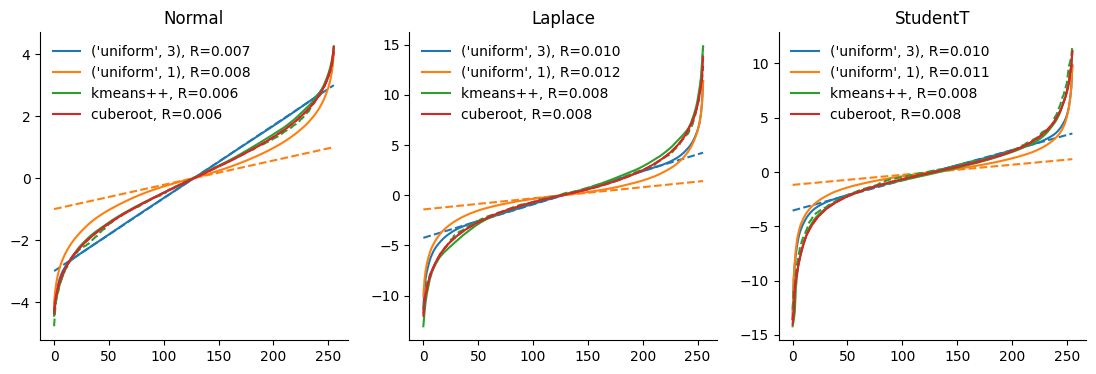

In [ ]:
bits = 8

distributions = [
    dict(dist="Normal"),
    dict(dist="Laplace"),
    dict(dist="StudentT", dof=7),
]
_, axs = plt.subplots(ncols=len(distributions), figsize=(4.5*len(distributions), 4))
for dist, ax in zip(distributions, axs):
    X = sample(2**20, **dist, seed=100)
    for init, c in zip([("uniform", 3), ("uniform", 1), "kmeans++", "cuberoot"], sns.color_palette()):
        fmt = Q.lut_lloyd_max(X, bits, 1e-4, init=init)
        rmse = Q.rmse_norm(X, fmt.quantise(X))
        ax.plot(fmt.values, label=f"{init}, R={rmse:.3f}", color=c)
        ax.plot(Q._lloyd_max_init(init, Q.shuffle(X.float()), 2**bits).cpu(), ls="--", color=c)
    ax.legend()
    ax.set_title(dist["dist"])

In [21]:
model = E.RequantisableModel.load("meta-llama/Llama-3.2-1B", DEVICE, torch.bfloat16)
params = {k: v.detach() for k, v in model.model.named_parameters() if v.ndim == 2}

In [ ]:
pd.DataFrame.from_records(dict(name=k, n=v.nelement(), tail4=(v.abs() > 4*v.std()).float().mean().item()) for k, v in params.items()).sort_values("tail4")

,name,n,tail4
90,model.layers.12.mlp.up_proj.weight,16777216,0.000147
6,model.layers.0.mlp.up_proj.weight,16777216,0.000157
20,model.layers.2.mlp.up_proj.weight,16777216,0.000170
97,model.layers.13.mlp.up_proj.weight,16777216,0.000171
83,model.layers.11.mlp.up_proj.weight,16777216,0.000194
...,...,...,...
71,model.layers.10.self_attn.q_proj.weight,4194304,0.003408
101,model.layers.14.self_attn.v_proj.weight,1048576,0.003414
64,model.layers.9.self_attn.q_proj.weight,4194304,0.003612
108,model.layers.15.self_attn.v_proj.weight,1048576,0.003613


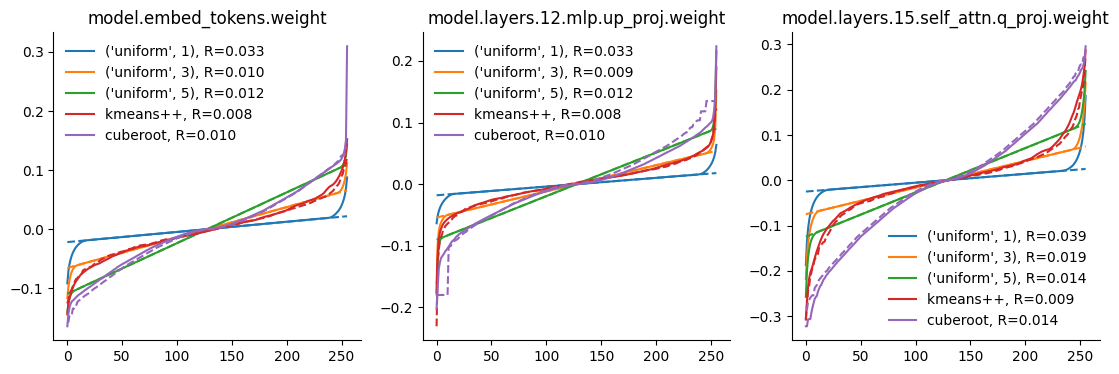

In [30]:
bits = 8

param_names = [
    "model.embed_tokens.weight",
    "model.layers.12.mlp.up_proj.weight",
    "model.layers.15.self_attn.q_proj.weight",
]
_, axs = plt.subplots(ncols=len(param_names), figsize=(4.5*len(param_names), 4))
for p, ax in zip(param_names, axs):
    X = params[p].detach()
    for init, c in zip([("uniform", 1), ("uniform", 3), ("uniform", 5), "kmeans++", "cuberoot"], sns.color_palette()):
        fmt = Q.lut_lloyd_max(X, bits, 1e-4, init=init)
        rmse = Q.rmse_norm(X, fmt.quantise(X))
        ax.plot(fmt.values, label=f"{init}, R={rmse:.3f}", color=c)
        ax.plot(Q._lloyd_max_init(init, Q.shuffle(X).float().flatten(), 2**bits).cpu(), ls="--", color=c)
    ax.legend()
    ax.set_title(p)